In [62]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from lime.lime_tabular import LimeTabularExplainer
import shap
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("Telecom Churn Prediction.csv")

In [4]:
df.drop("customerID", axis=1, inplace=True)

In [5]:
# Define a mapping dictionary

df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
df['MultipleLines'] = df['MultipleLines'].map({'No': 0, 'Yes': 1, 'No phone service': 2})
df['Contract'] = df['Contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})
df['InternetService'] = df['InternetService'].map({'No': 0, 'DSL': 1, 'Fiber optic': 2})
df['PaymentMethod'] = df['PaymentMethod'].map({'Electronic check': 0, 'Mailed check': 1, 'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3})
df['TotalCharges']=df['TotalCharges'].replace({' ': 0})
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

for col in ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']:
    df[col] = df[col].map({'No': 0, 'Yes': 1})
for col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    df[col] = df[col].map({'No': 0, 'Yes': 1, 'No internet service': 2})

In [6]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,2,1,0,1,0,0,0,0,0,1,0,29.85,29.85,0
1,0,0,0,0,34,1,0,1,1,0,1,0,0,0,1,0,1,56.95,1889.50,0
2,0,0,0,0,2,1,0,1,1,1,0,0,0,0,0,1,1,53.85,108.15,1
3,0,0,0,0,45,0,2,1,1,0,1,1,0,0,1,0,2,42.30,1840.75,0
4,1,0,0,0,2,1,0,2,0,0,0,0,0,0,0,1,0,70.70,151.65,1


In [7]:
# Using min max scaler technique on tenure, monthlycharges and total charges column

scaler = MinMaxScaler()
df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])

In [8]:
# Splitting the data

X = df.drop("Churn", axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=100)

In [9]:
smote = SMOTE(random_state=42)
X_oversampled, y_oversampled = smote.fit_resample(X_train, y_train)
print("Shape of X_oversampled:", X_oversampled.shape)
print("Shape of y_oversampled:", y_oversampled.shape)

Shape of X_oversampled: (3120, 19)
Shape of y_oversampled: (3120,)


In [11]:
# Logistic regression 
logistic = LogisticRegression()

In [12]:
# Testing data
logistic.fit(X_train, y_train)

predict = logistic.predict(X_test)

accuracy = accuracy_score(y_test, predict)
print(f"Testing Accuracy: {accuracy * 100:.2f}%")

Testing Accuracy: 79.42%


In [67]:
target_names = y_train.unique().tolist()

feature_names = X_train.columns.tolist()

In [53]:
explainer = LimeTabularExplainer(X_train.values, feature_names=feature_names, class_names=target_names, discretize_continuous=True)

# Choose an instance to explain
idx = 1000
exp = explainer.explain_instance(X_test.iloc[idx].values, logistic.predict_proba)

# Print the explanation for each class
print(exp.show_in_notebook(show_all=False)) # For Jupyter notebooks


/Users/fatemi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


None


In [60]:
# Initialize the SHAP explainer with the trained model
explainer = shap.Explainer(logistic, X_train)

X_test_instance = X_test.iloc[[0]]  

shap_values = explainer.shap_values(X_test_instance)

# Visualize the explanation for this instance
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test_instance)

Variable Importance Plot - Global Interpretation


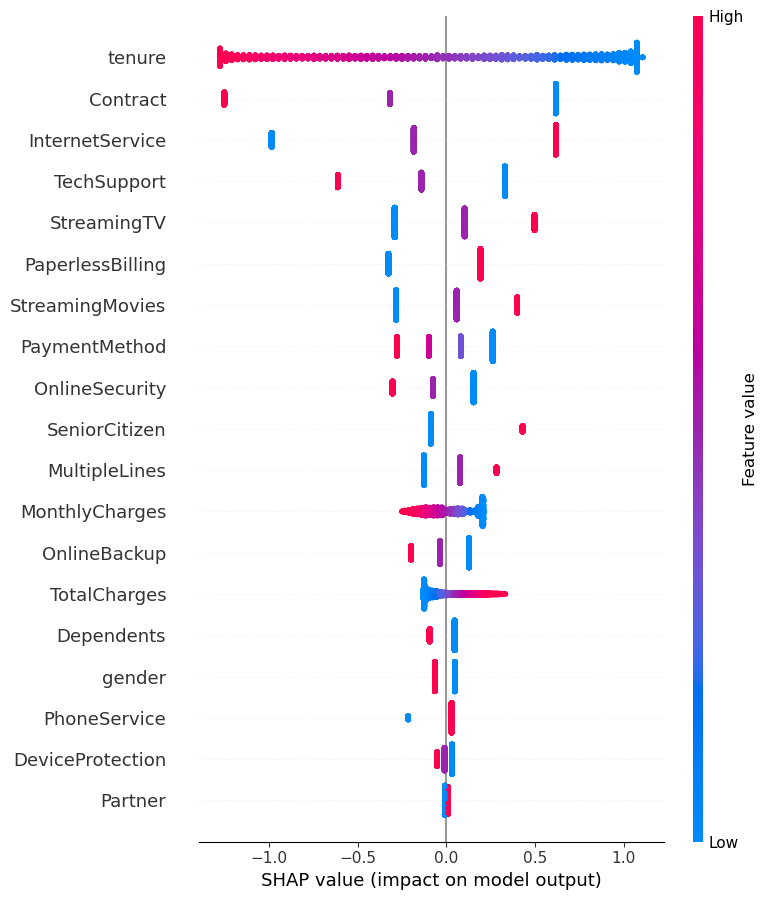

In [64]:
shap_values = explainer.shap_values(X_test)
shap_values = explainer.shap_values(X_test)
print("Variable Importance Plot - Global Interpretation")
figure = plt.figure()
shap.summary_plot(shap_values, X_test)

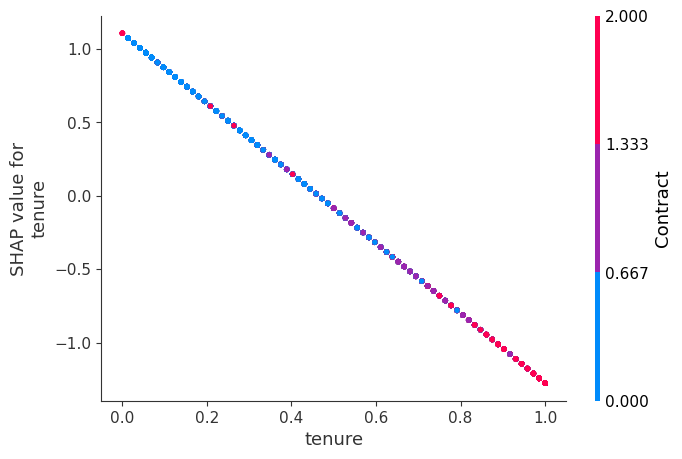

In [66]:
shap.dependence_plot("tenure", shap_values, X_test)